<a href="https://www.kaggle.com/code/mabubakarkhalid/simple-gan-learning?scriptVersionId=190229658" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 1. Importing libraries

In [1]:
#!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

2024-07-29 03:27:40.850318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 03:27:40.850429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 03:27:40.973997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Use the tensorflow datasets api to bring in the data source


In [3]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGFT3MZ/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGFT3MZ/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
# Dataset is being received as dictionary
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

### 2.1 Visualize the data

In [5]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [6]:
# Getting data out of the pipeline
# dataiterator.next()['image']

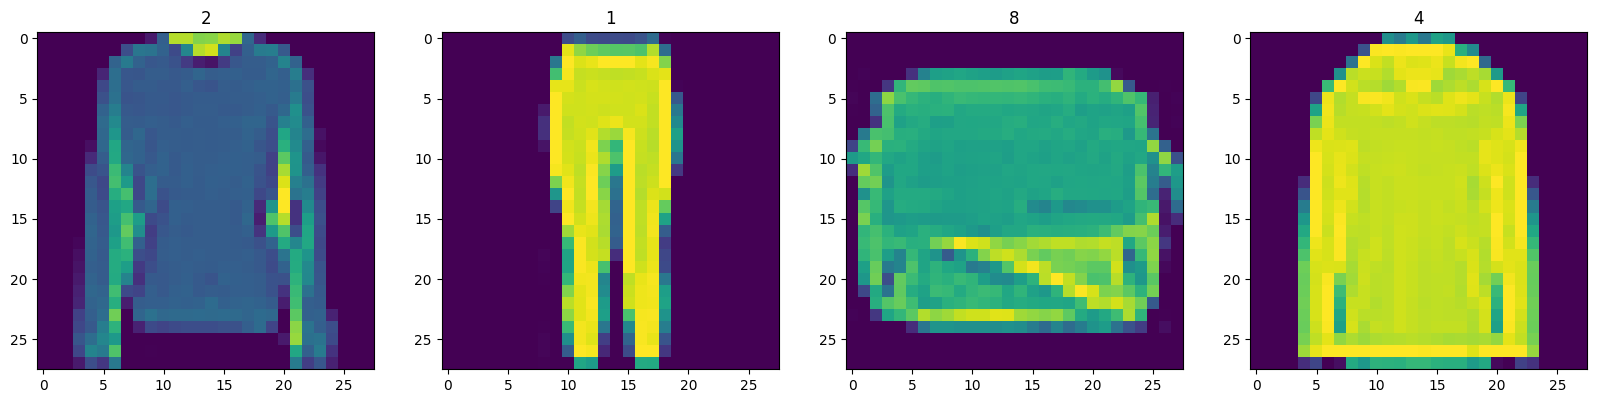

In [7]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [8]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [9]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

The above code snippet prepares the training data for a machine learning model by:

* Loading the dataset
* Preprocessing the images
* Caching for faster access
* Shuffling to avoid order-based biases
* Batching for efficient training
* Prefetching to minimize I/O delays

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Building a Generator

In [11]:
strategy = tf.distribute.MirroredStrategy()

In [12]:
from tensorflow.keras import Sequential

In [13]:
import tensorflow as tf
import keras
from keras import layers

In [14]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [15]:
with strategy.scope():
    def build_generator():
        model = tf.keras.models.Sequential()

        # Takes in random values and reshapes it to 7x7x128
        # Beginnings of a generated image
        model.add(Dense(7*7*128, input_dim=128))
        model.add(LeakyReLU(0.2))
        model.add(Reshape((7,7,128)))

        # Upsampling block 1
        model.add(UpSampling2D())
        model.add(Conv2D(128, 5, padding='same'))
        model.add(LeakyReLU(0.2))

        # Upsampling block 2
        model.add(UpSampling2D())
        model.add(Conv2D(128, 5, padding='same'))
        model.add(LeakyReLU(0.2))

        # Convolutional block 1
        model.add(Conv2D(128, 4, padding='same'))
        model.add(LeakyReLU(0.2))

        # Convolutional block 2
        model.add(Conv2D(128, 4, padding='same'))
        model.add(LeakyReLU(0.2))

        # Conv layer to get to one channel
        model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

        return model
    
    
    generator = build_generator()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
img = generator.predict(np.random.randn(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


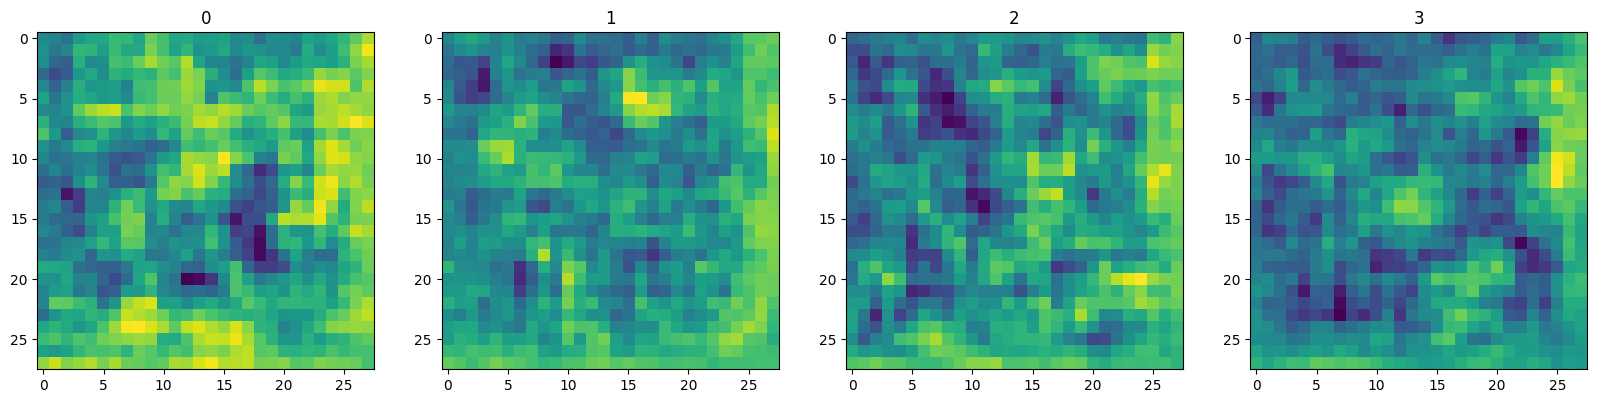

In [19]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

## 4. Build Discriminator


In [20]:
with strategy.scope():
    def build_discriminator():
        model = Sequential()

        # First Conv Block
        model.add(Conv2D(32, 5, input_shape = (28,28,1)))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))

        # Second Conv Block
        model.add(Conv2D(64, 5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))

        # Third Conv Block
        model.add(Conv2D(128, 5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))

        # Fourth Conv Block
        model.add(Conv2D(256, 5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))

        # Flatten then pass to dense layer
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        return model
    
    
    discriminator = build_discriminator()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# discriminator = build_discriminator()

In [22]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# img = img[0]

In [24]:
# img = np.expand_dims(img, axis=0)  # Add a batch dimension

In [25]:
# discriminator.predict(img)

## 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [26]:
# g_opt = tf.keras.optimizers.Adam(0.0001)
# d_opt = tf.keras.optimizers.Adam(0.00001)

In [27]:
# g_loss = tf.keras.losses.BinaryCrossentropy()
# d_loss = tf.keras.losses.BinaryCrossentropy()

### 4.2 Build Subclassed Model


In [28]:
# Importing the base model class to subclass our training step
from tensorflow.keras import Model

In [29]:
with strategy.scope():
    
    g_opt = tf.keras.optimizers.Adam(0.0001)
    d_opt = tf.keras.optimizers.Adam(0.00001)
    
    g_loss = tf.keras.losses.BinaryCrossentropy()
    d_loss = tf.keras.losses.BinaryCrossentropy()
    
    class FashionGAN(Model):
        def __init__(self, generator, discriminator, *args, **kwargs):
            # Pass through args and kwargs to base class
            super().__init__(*args, **kwargs)

            # Create attributes for gen and disc
            self.generator = generator
            self.discriminator = discriminator

        def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
            # Compile with base class
            super().compile(*args, **kwargs)

            # Create attributes for losses and optimizers
            self.g_opt = g_opt
            self.d_opt = d_opt
            self.g_loss = g_loss
            self.d_loss = d_loss

        def train_step(self, batch):
            # Get the data
            real_images = batch
            fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

            # Train the discriminator
            with tf.GradientTape() as d_tape:
                # Pass the real and fake images to the discriminator model
                yhat_real = self.discriminator(real_images, training=True)
                yhat_fake = self.discriminator(fake_images, training=True)
                yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

                # Create labels for real and fakes images
                y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

                # Add some noise to the TRUE outputs
                noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
                noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
                y_realfake += tf.concat([noise_real, noise_fake], axis=0)

                # Calculate loss - BINARYCROSS
                total_d_loss = self.d_loss(y_realfake, yhat_realfake)

            # Apply backpropagation - nn learn
            dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
            self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

            # Train the generator
            with tf.GradientTape() as g_tape:
                # Generate some new images
                gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

                # Create the predicted labels
                predicted_labels = self.discriminator(gen_images, training=False)

                # Calculate loss - trick to training to fake out the discriminator
                total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

            # Apply backprop
            ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
            self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

            return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:
# # Create instance of subclassed model
# fashgan = FashionGAN(generator, discriminator)

In [31]:
# Compile the model
# fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [32]:
with strategy.scope():
    class ModelMonitor(tf.keras.callbacks.Callback):
        def __init__(self, num_img=3, latent_dim=128):
            self.num_img = num_img
            self.latent_dim = latent_dim

        def on_epoch_end(self, epoch, logs=None):
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f'/kaggle/working/generated_img_{epoch}_{i}.png')

            generator.save('generator.h5')
            discriminator.save('discriminator.h5')

In [33]:
# Callback class to save the model after every epoch to save the training progress
with strategy.scope():    
    checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        verbose=0,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
        save_best_only=False)

## 4.4 Train the model

In [34]:

# with strategy.scope():

#     fashgan = FashionGAN(generator, discriminator)
#     fashgan.compile(g_opt, d_opt, g_loss, d_loss)

#     hist = fashgan.fit(ds, epochs=350, callbacks=[ModelMonitor(),model_checkpoint_callback])
        



# Calling the same function again will resume from where we left off
# run_training(epochs=1)




In [35]:
# run_training()

In [36]:
# Recommend 2000 epochs
# hist = fashgan.fit(ds, epochs=300, callbacks=[ModelMonitor(),model_checkpoint_callback])

## Resume Training

At times, we might not be able to complete the training epochs due to session limitations or may be we want to change the learning rate. in both cases, we need to restart the training process from where it is stopped. To do this, there are two methods that I have tried here.

### 1. Saving wieghts in Callback Class
We can add ***generator.save('generator.h5')*** and ***discriminator.save('discriminator.h5')**** in the callback class and it will create the respective files containing weights for both generator and discriminator after each epoch that we can use later on for inference or resume training process if it has ended.

### 2. Saving weights using model checkpoint method:
The second method is to use ***tf.keras.callbacks.ModelCheckpoint*** method to save the weights of entire model that includes both generator and discriminator model in the same file.

Both of these methods are simple to understand and easy to use.

After reloading the weights, we can restart the training process by defining ***model.fit***

In [37]:
with strategy.scope():
    generator.load_weights("/kaggle/input/simple-gan-training-1000-epochs/keras/default/1/generator.h5")
    discriminator.load_weights('/kaggle/input/simple-gan-training-1000-epochs/keras/default/1/discriminator.h5')
    

    fashgan = FashionGAN(generator, discriminator)
    fashgan.compile(g_opt, d_opt, g_loss, d_loss)

    hist = fashgan.fit(ds, epochs=300, callbacks=[ModelMonitor(),model_checkpoint_callback])
        


Epoch 1/300


2024-07-29 03:28:48.934132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - d_loss: 0.6801 - g_loss: 0.6436
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6844 - g_loss: 0.6551
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6821 - g_loss: 0.6652
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6844 - g_loss: 0.6524
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6808 - g_loss: 0.6661
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6886 - g_loss: 0.6743
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6761 - g_loss: 0.6662
Epoch 8/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6664 - g_loss: 0.6751
Epoch 9/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6764 - g_loss: 0.6808
Epoch 10/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6842 - g_loss: 0.6468
Epoch 11/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - d_loss: 0.6749 - g_loss: 0.6519
Epoch 12/300
469/469 ━━━━━━━━━━

In [38]:
#  discriminator.load_weights('/kaggle/input/simple-gan-learning-350-epochs/keras/default/1/discriminator.h5')

In [39]:
# class FashionGAN(Model):
#     def __init__(self, generator, discriminator, *args, **kwargs):
#         # Pass through args and kwargs to base class
#         super().__init__(*args, **kwargs)

#         # Create attributes for gen and disc
#         self.generator = generator
#         self.discriminator = discriminator

#     def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
#         # Compile with base class
#         super().compile(*args, **kwargs)

#         # Create attributes for losses and optimizers
#         self.g_opt = g_opt
#         self.d_opt = d_opt
#         self.g_loss = g_loss
#         self.d_loss = d_loss

#     def train_step(self, batch):
#         # Get the data
#         real_images = batch
#         fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

#         # Train the discriminator
#         with tf.GradientTape() as d_tape:
#             # Pass the real and fake images to the discriminator model
#             yhat_real = self.discriminator(real_images, training=True)
#             yhat_fake = self.discriminator(fake_images, training=True)
#             yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

#             # Create labels for real and fakes images
#             y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

#             # Add some noise to the TRUE outputs
#             noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
#             noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
#             y_realfake += tf.concat([noise_real, noise_fake], axis=0)

#             # Calculate loss - BINARYCROSS
#             total_d_loss = self.d_loss(y_realfake, yhat_realfake)

#         # Apply backpropagation - nn learn
#         dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
#         self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

#         # Train the generator
#         with tf.GradientTape() as g_tape:
#             # Generate some new images
#             gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

#             # Create the predicted labels
#             predicted_labels = self.discriminator(gen_images, training=False)

#             # Calculate loss - trick to training to fake out the discriminator
#             total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

#         # Apply backprop
#         ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
#         self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

#         return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [40]:
# Create instance of subclassed model
# fashgan = FashionGAN(generator, discriminator)

In [41]:
# Compile the model
# fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [42]:
# class ModelMonitor(tf.keras.callbacks.Callback):
#     def __init__(self, num_img=3, latent_dim=128):
#         self.num_img = num_img
#         self.latent_dim = latent_dim

#     def on_epoch_end(self, epoch, logs=None):
#         random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images *= 255
#         generated_images.numpy()
#         for i in range(self.num_img):
#             img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
#             img.save(f'/kaggle/working/generated_img_{epoch}_{i}.png')
        
#         generator.save('generator.h5')
#         discriminator.save('discriminator.h5')

In [43]:
# Callback class to save the model after every epoch to save the training progress
# checkpoint_path = '/kaggle/working/checkpoint.weights.h5'
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)


In [44]:
# hist = fashgan.fit(ds, epochs=500, callbacks=[ModelMonitor(),cp_callback])

### 4.4 Review Performance

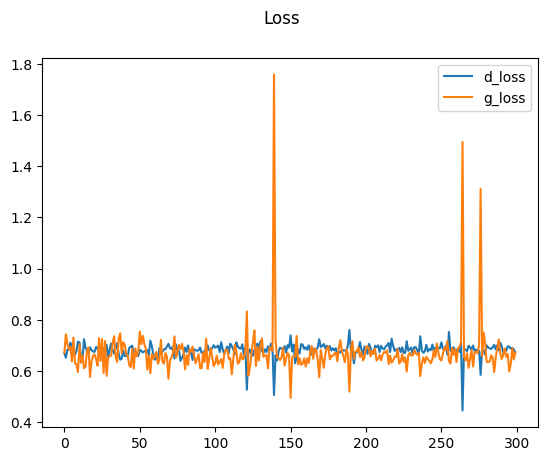

In [45]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## 5. Test Out the Generator

### 5.1 Generate Images


In [46]:
import os

In [47]:
generator.load_weights(os.path.join('/kaggle/working', 'generator.h5'))

In [48]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


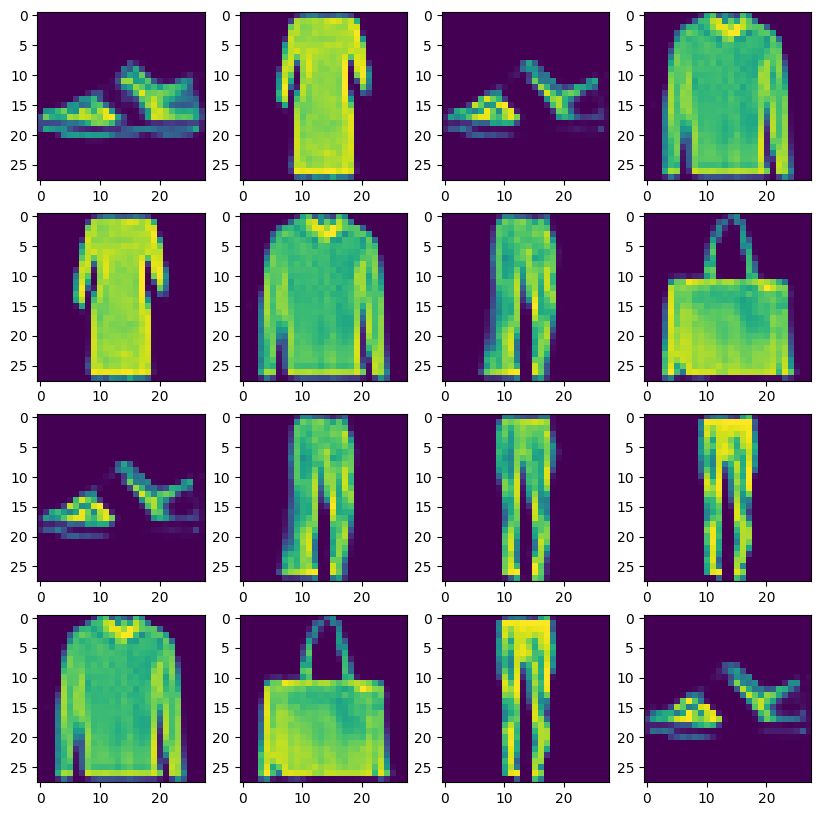

In [49]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [50]:
# generator.save('generator.h5')
# discriminator.save('discriminator.h5')

In [51]:
#This code is to empty the output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)